<a href="https://colab.research.google.com/github/Anithasadhanala/colorize_image/blob/main/colorize_image_Anitha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.device(0))
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

0
1
Tesla T4


In [ ]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:01<00:00, 103766244.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Define the colorization model
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

In [ ]:
model = ColorizationNet().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert RGB image to grayscale
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)


In [ ]:
# Training loop
EPOCHS = 30
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        # Forward pass
        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Finished Training")


Epoch [1/30], Step [1/782], Loss: 0.0606
Epoch [1/30], Step [101/782], Loss: 0.0092
Epoch [1/30], Step [201/782], Loss: 0.0059
Epoch [1/30], Step [301/782], Loss: 0.0052
Epoch [1/30], Step [401/782], Loss: 0.0058
Epoch [1/30], Step [501/782], Loss: 0.0080
Epoch [1/30], Step [601/782], Loss: 0.0048
Epoch [1/30], Step [701/782], Loss: 0.0054
Epoch [2/30], Step [1/782], Loss: 0.0048
Epoch [2/30], Step [101/782], Loss: 0.0057
Epoch [2/30], Step [201/782], Loss: 0.0047
Epoch [2/30], Step [301/782], Loss: 0.0052
Epoch [2/30], Step [401/782], Loss: 0.0051
Epoch [2/30], Step [501/782], Loss: 0.0052
Epoch [2/30], Step [601/782], Loss: 0.0060
Epoch [2/30], Step [701/782], Loss: 0.0071
Epoch [3/30], Step [1/782], Loss: 0.0053
Epoch [3/30], Step [101/782], Loss: 0.0051
Epoch [3/30], Step [201/782], Loss: 0.0056
Epoch [3/30], Step [301/782], Loss: 0.0074
Epoch [3/30], Step [401/782], Loss: 0.0050
Epoch [3/30], Step [501/782], Loss: 0.0047
Epoch [3/30], Step [601/782], Loss: 0.0043
Epoch [3/30], Ste

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Convert from Tensor image and display
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if len(img.shape) == 2:  # grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
    """
    Display grayscale, colorized, and original images side by side.
    n: number of images to display from the batch
    """
    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        # Display original grayscale image
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        # Display colorized image
        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def torch_rgb_to_hsv(rgb):
    """
    Convert an RGB image tensor to HSV.

    Parameters:
    - rgb: tensor of shape (batch_size, 3, height, width) in RGB format in the range [0, 1].

    Returns:
    - hsv: tensor of same shape in HSV format in the range [0, 1].
    """
    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val

    # Compute H
    h = torch.zeros_like(r)
    mask = (max_val == r) & (g >= b)
    h[mask] = (g[mask] - b[mask]) / diff[mask]
    mask = (max_val == r) & (g < b)
    h[mask] = (g[mask] - b[mask]) / diff[mask] + 6.0
    mask = max_val == g
    h[mask] = (b[mask] - r[mask]) / diff[mask] + 2.0
    mask = max_val == b
    h[mask] = (r[mask] - g[mask]) / diff[mask] + 4.0
    h = h / 6.0
    h[diff == 0.0] = 0.0

    # Compute S
    s = torch.zeros_like(r)
    s[diff != 0.0] = diff[diff != 0.0] / max_val[diff != 0.0]

    # V is just max_val
    v = max_val

    return torch.stack([h, s, v], dim=1)


def torch_hsv_to_rgb(hsv):
    """
    Convert an HSV image tensor to RGB.

    Parameters:
    - hsv: tensor of shape (batch_size, 3, height, width) in HSV format in the range [0, 1].

    Returns:
    - rgb: tensor of same shape in RGB format in the range [0, 1].
    """
    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = i % 6
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    r[i_mod == 0.0] = v[i_mod == 0.0]
    g[i_mod == 0.0] = t[i_mod == 0.0]
    b[i_mod == 0.0] = p[i_mod == 0.0]

    r[i_mod == 1.0] = q[i_mod == 1.0]
    g[i_mod == 1.0] = v[i_mod == 1.0]
    b[i_mod == 1.0] = p[i_mod == 1.0]

    r[i_mod == 2.0] = p[i_mod == 2.0]
    g[i_mod == 2.0] = v[i_mod == 2.0]
    b[i_mod == 2.0] = t[i_mod == 2.0]

    r[i_mod == 3.0] = p[i_mod == 3.0]
    g[i_mod == 3.0] = q[i_mod == 3.0]
    b[i_mod == 3.0] = v[i_mod == 3.0]

    r[i_mod == 4.0] = t[i_mod == 4.0]
    g[i_mod == 4.0] = p[i_mod == 4.0]
    b[i_mod == 4.0] = v[i_mod == 4.0]

    r[i_mod == 5.0] = v[i_mod == 5.0]
    g[i_mod == 5.0] = p[i_mod == 5.0]
    b[i_mod == 5.0] = q[i_mod == 5.0]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):
    """
    Exaggerate the colors of RGB images.

    Parameters:
    - images: tensor of shape (batch_size, 3, height, width) in RGB format.
    - saturation_factor: factor by which to increase the saturation. Default is 1.5.
    - value_factor: factor by which to increase the value/brightness. Default is 1.2.

    Returns:
    - color_exaggerated_images: tensor of same shape as input, with exaggerated colors.
    """
    # Convert images to the range [0, 1]
    images = (images + 1) / 2.0

    # Convert RGB images to HSV
    images_hsv = torch_rgb_to_hsv(images)

    # Increase the saturation and value components
    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)

    # Convert the modified HSV images back to RGB
    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)

    # Convert images back to the range [-1, 1]
    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images



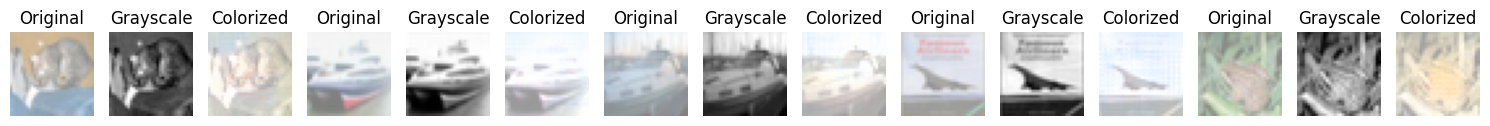

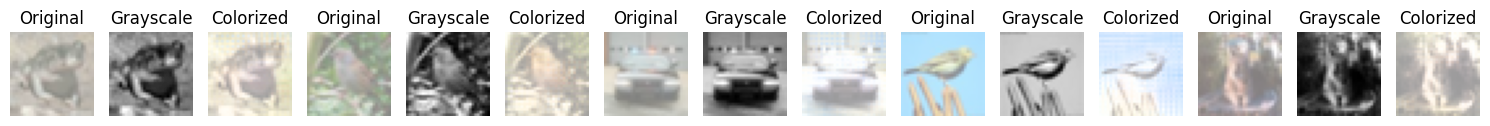

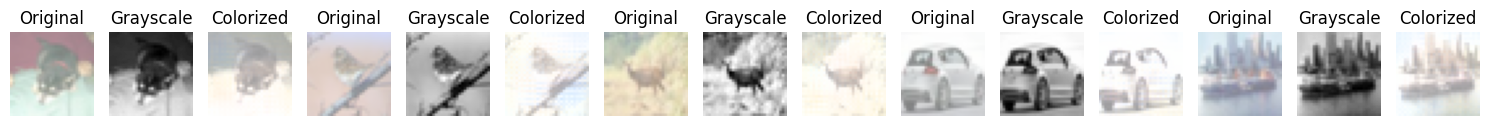

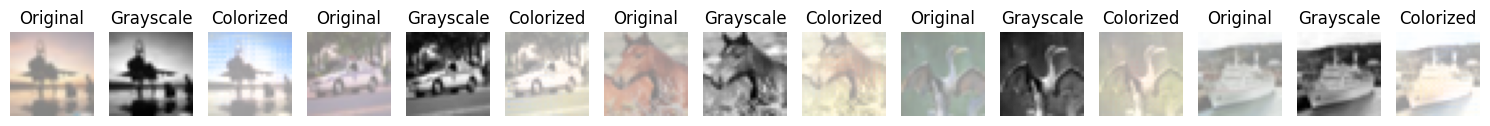

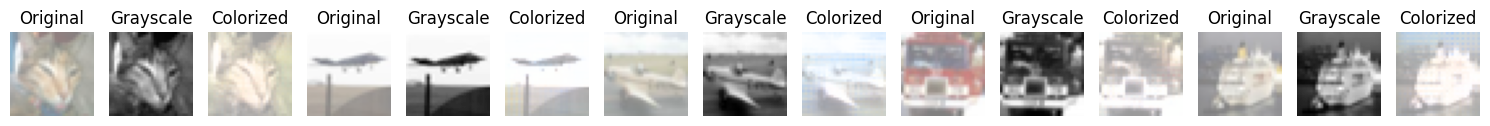

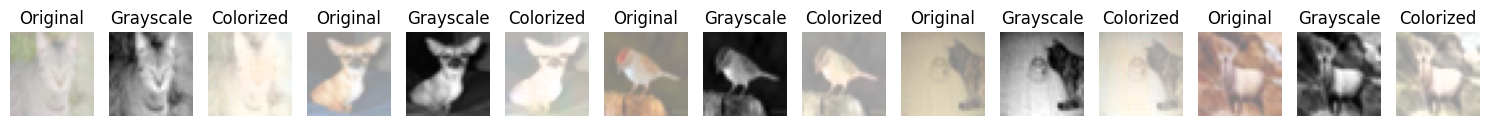

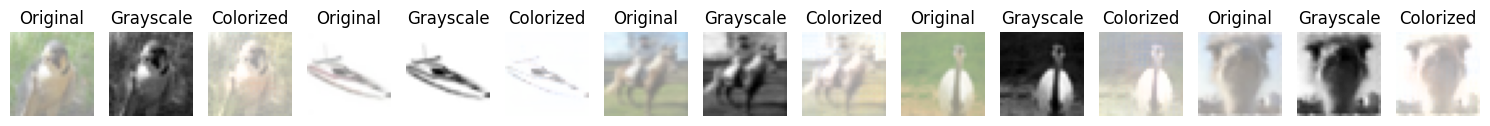

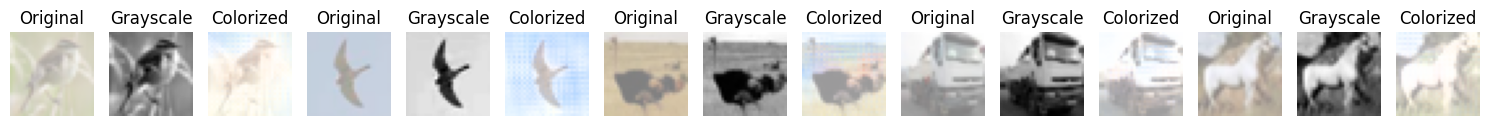

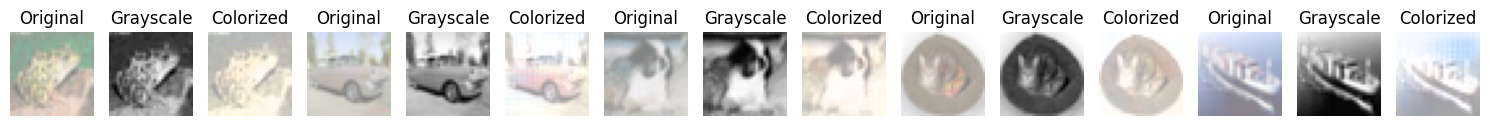

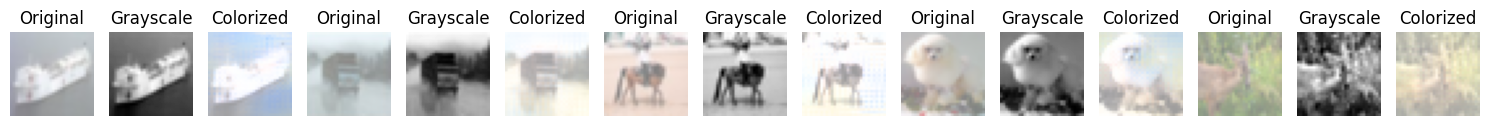

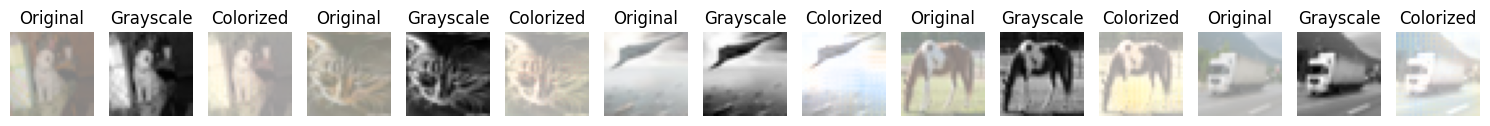

In [ ]:
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        colorized_images = model(grayscale_images)

        # Convert the tensors back to CPU for visualization
        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)  # remove the color channel
        colorized_images_cpu = colorized_images.cpu()
        original_images_cpu = images.cpu()

        #colorized_images_cpu=scale_predicted_colors(colorized_images_cpu)
        colorized_images_cpu=exaggerate_colors(colorized_images_cpu)

        # Visualize the grayscale, colorized, and original images
        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

        if i == 10:  # only do this for up to certain batch for demonstration purposes
            break

In [ ]:
from PIL import Image

# Open the image. (Keep your image in the current directory. In my case, the image was horse.jpg)
img = Image.open("/content/lion.jpg")

# Convert the image to grayscale
gray_img = img.convert("L")

In [ ]:
import torchvision.transforms as transforms

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # If you need to normalize, uncomment the following line
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming you want to normalize to [-1, 1] range
])



In [ ]:
# Apply the transformations
img_tensor = transform(gray_img).unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Move the image tensor to the device where your model is (likely 'cuda' if using GPU)
img_tensor = img_tensor.to(device)

# Get the model's output
with torch.no_grad():
    colorized_tensor = model(img_tensor)


In [ ]:
# Convert the tensor back to an image
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

# Optionally, save the image
colorized_img.save("/content/lion_colorize.jpg")


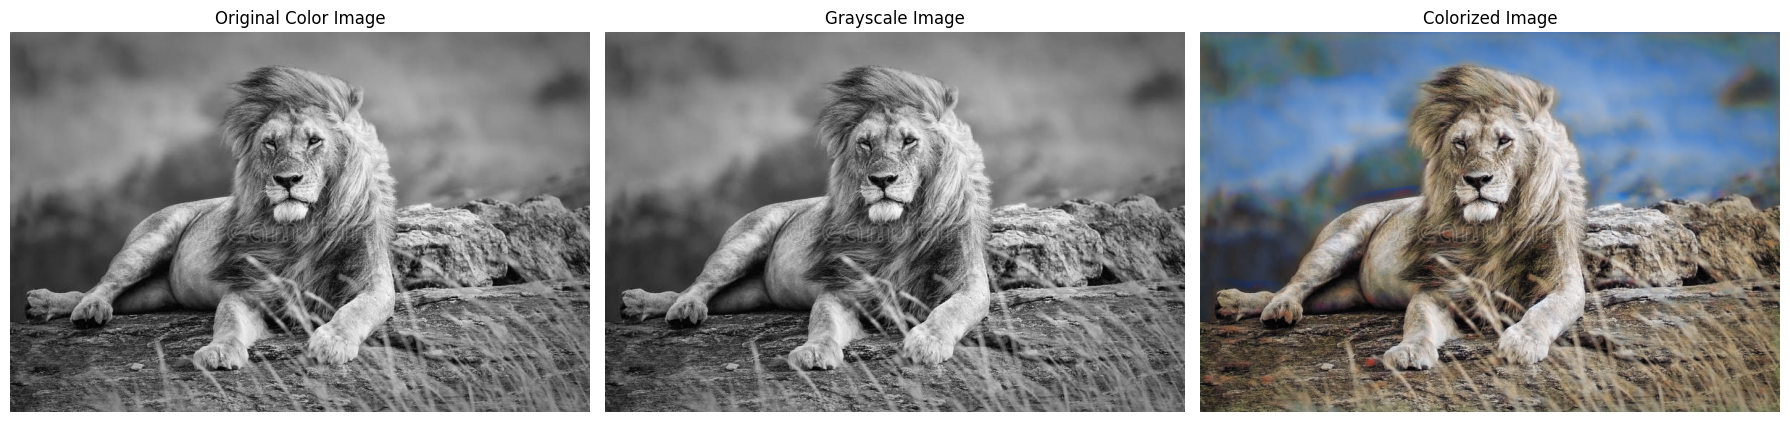

In [ ]:
# Plotting the original, grayscale, and colorized images side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with 1 row and 3 columns

# Display original color image
ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')  # Hide axes

# Display grayscale image
ax[1].imshow(gray_img, cmap='gray')  # Since it's grayscale, use cmap='gray'
ax[1].set_title("Grayscale Image")
ax[1].axis('off')  # Hide axes

# Display colorized image
ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()

In [ ]:
gray_img.save("./lion_colorize.jpg")